In [5]:
from torch.utils.data import Dataset, DataLoader
from typing import List
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
import torch
from transformers import BertForTokenClassification, AdamW
from sklearn.metrics import classification_report

#https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/
#https://huggingface.co/transformers/model_doc/bert.html#bertfortokenclassification
#https://vamvas.ch/bert-for-ner
#https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

In [8]:
def read_data(file):
  lines = open(file, "r").readlines()
  data = {"sentences": [], "labels_per_sent": []}
  sentence, labels = [], []
  for line in tqdm(lines):
    line = line.strip()
    if not line:
      if sentence and labels:
        assert len(sentence) == len(labels)
        data["sentences"].append(sentence)
        data["labels_per_sent"].append(labels)
        sentence, labels = [], []
      continue
    if line.startswith("-DOCSTART-"):
      continue
    else:
      values = line.split(" ")
      try:
        token, _, _, label = values
        sentence.append(token)
        if label != 'O':
          labels.append(label.split('-')[-1])
        else:
          labels.append(label)

      except Exception as e:
        print(f"Error has occur: {e}")
        continue
  return data


train = read_data("/content/drive/MyDrive/Akatsuki/eng.train")
valid = read_data("/content/drive/MyDrive/Akatsuki/eng.testa")

100%|██████████| 55045/55045 [00:00<00:00, 979107.32it/s]


In [9]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased', do_lower_case=False, is_split_into_words = True)

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/master.zip" to /root/.cache/torch/hub/master.zip


In [10]:
import numpy as np
def tokenize(features, labels):
    input_ids = np.array([tokenizer.encode(txt, truncation = True, padding='max_length', max_length =  150,  is_split_into_words = True) for txt in features])

    labels_ids = np.array([tokenizer.encode(lab, truncation = True, padding='max_length', max_length =  150,  is_split_into_words = True) for lab in labels])

    input_ids = np.stack(input_ids, axis = 0)
    
    labels_ids = np.stack(labels_ids, axis = 0)
    
    attention_masks = [[float(i != 0) for i in ii] for ii in input_ids]
    return input_ids, labels_ids, attention_masks 
    
class NERDataset(Dataset):

  def __init__(self, data):
    self.features = data['sentences']
    
    self.enc_feat, self.enc_lab, self.attention_mask = tokenize(data['sentences'], data['labels_per_sent'])
  def __getitem__(self, index):
    feature = torch.LongTensor(self.enc_feat[index])
    label = torch.LongTensor(self.enc_lab[index])
    attention_mask = torch.LongTensor(self.attention_mask[index])
    
    return feature, label, attention_mask
    
  def __len__(self):
    return len(self.features)

train_dataset = NERDataset(train)
valid_dataset = NERDataset(valid)

In [11]:
train_datloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_datloader = DataLoader(valid_dataset, batch_size=4, shuffle=True)

In [12]:
class NERModel(nn.Module):

  def __init__(self):
    super(NERModel, self).__init__()
    
    options_name = "bert-base-cased"
    self.encoder = BertForTokenClassification.from_pretrained(options_name, 
    output_attentions = False,
    num_labels=26575,
    output_hidden_states = False)


  def forward(self, text, mask, label):
    output = self.encoder(text,token_type_ids=None,attention_mask = mask, labels=label)
    loss = output['loss']
    logits = output['logits']
    
    return loss, logits

    
    

device = 'cuda'
model = NERModel().to(device)
model.to(device)
optimizer = AdamW(
    model.parameters(),
    lr=3e-4,
    eps=1e-8
)    

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [13]:
def transform_logits(predictions: List[torch.tensor]):
  predicted = torch.max(predictions, 2).values

  ls_predicted = []
  for i in predicted:
  
    ls_predicted.append(tokenizer.decode(i.int()))
  return ls_predicted

def transform_target(target_labels: List[torch.tensor]):
  list_gt = []
  for i in target_labels:
    list_gt.append(tokenizer.decode(i))
  return list_gt  


def count_metrics(gold_labels_per_sentence: List[List[str]], predict_labels_per_sentence: List[List[str]]):
  gold_labels = [l for l_per_sent in gold_labels_per_sentence for l in l_per_sent]
  predict_labels = [l for l_per_sent in predict_labels_per_sentence for l in l_per_sent]
  print(classification_report(gold_labels, predict_labels))  

In [14]:
from tqdm import tqdm
losses = {"train_losses": [], "valid_losses": []}

epochs = 3
device = 'cuda'
for epoch in range(epochs):

  print(f"Start eposh #{epoch}")
  cnt = 0
  model.train()
  for text, label, mask in train_datloader:

    text = text.to(device)
    label = label.to(device)
    mask = mask.to(device)
    optimizer.zero_grad()
    
    loss, logits = model.forward(text, mask, label)
   
    
    losses["train_losses"].append(loss)
    cnt += 1
    if cnt % 500 == 0:
      print(f'idx: {cnt} and loss is" {loss}')
    loss.backward()
    
    optimizer.step()
    
    predict_labels, gold_labels = [], []
    
  model.eval()
  print('Evaluate.....')
  predictions, true_labels = [], []
  for text, label, mask in valid_datloader:
    text = text.to(device)
    label = label.to(device)
    mask = mask.to(device)

    with torch.no_grad():
      loss, logits = model.forward(text, mask, label)
    losses["valid_losses"].append(loss)
    
    gold_labels.append(transform_target(label))
    predict_labels.append(transform_logits(logits))
   

  #count_metrics(gold_labels, predict_labels)
  
  print(f"End eposh #{epoch}")
  print('-------------------------------')



Start eposh #0
idx: 500 and loss is" 2.274463176727295
idx: 1000 and loss is" 1.7463831901550293
idx: 1500 and loss is" 1.8485385179519653
idx: 2000 and loss is" 2.5487654209136963
idx: 2500 and loss is" 1.780705451965332
idx: 3000 and loss is" 1.4717597961425781
idx: 3500 and loss is" 1.707107424736023
Evaluate.....
End eposh #0
-------------------------------
Start eposh #1
idx: 500 and loss is" 1.881819486618042
idx: 1000 and loss is" 1.552380919456482
idx: 1500 and loss is" 1.8568886518478394
idx: 2000 and loss is" 1.7593249082565308
idx: 2500 and loss is" 2.2507927417755127
idx: 3000 and loss is" 1.178533673286438
idx: 3500 and loss is" 1.3588533401489258
Evaluate.....
End eposh #1
-------------------------------
Start eposh #2
idx: 500 and loss is" 1.4642711877822876
idx: 1000 and loss is" 1.6729559898376465
idx: 1500 and loss is" 1.4839366674423218
idx: 2000 and loss is" 1.7282438278198242
idx: 2500 and loss is" 1.362998604774475
idx: 3000 and loss is" 1.3039371967315674
idx: 35

In [34]:
def Average(lst):
    return sum(lst) / len(lst)

def loss_by_epoch(loss, step):
  epoch_loss = []
  start = 0
  for i in range(0, 3):
    epoch_loss.append(Average(loss[start:start + step]))
    start += step
  return epoch_loss  

valid_epoch = loss_by_epoch(losses['valid_losses'],int(len(losses['valid_losses']) / epochs) )

train_epoch = loss_by_epoch(losses['train_losses'],int(len(losses['train_losses']) / epochs) )


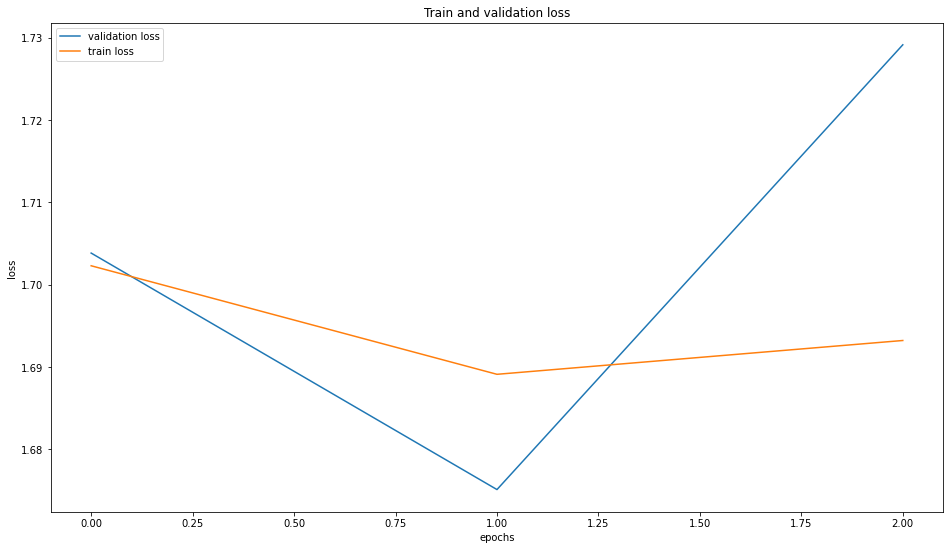

In [44]:
epoch = [i for i in range(0, epochs)]

fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(epoch, valid_epoch, label = 'validation loss')
ax.plot(epoch, train_epoch, label = 'train loss')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('Train and validation loss')
ax.legend()